# Hazard assessment for heavy snowfall & blizzards

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [SNOW](https://github.com/CLIMAAX/SNOW) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

In this workflow, our aim is to understand the present probability of severe snowfall and blizzards and pinpoint the particular regions in Europe that are highly impacted. We also aim to explore how the changing climate alters the occurrence of severe snowfall and blizzards.

The assessment is done using impact-based indicators for snowfall and blizzards, which are computed using ERA5 and EURO-CORDEX data. Annual probability of heavy snowfall and blizzards is then computed. For the description of the impact-based indicators and overall methodology, please see the [risk workflow description](Risk_workflow_description_SNOW_BLIZZARDS.md).

## Preparation work

### Load libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [warnings](https://docs.python.org/3/library/warnings.html) - To control the Python warning message 
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [cdsapi](https://pypi.org/project/cdsapi/) - To access the  CDS data
- [numpy](https://numpy.org) - Numerical computing tools  
- [xarray](https://docs.xarray.dev/en/stable/) - To process the NetCDF data and prepare it for further calculation
- [pyproj](https://pyproj4.github.io/pyproj/stable/) - Cartographic projections and coordinate transformations library
- [matplotlib](https://matplotlib.org/) - To plot the maps 
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
:::

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import os
import zipfile

import cdsapi
import numpy as np
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Select area of interest

Before downloading the data, we will define the coordinates of the area of interest. Using these coordinates, we can clip the datasets for further processing and generate hazard maps for the selected area. Please also specify a name for this area, which will be used in plots and saved results.

You can use the [Bounding Box tool](https://boundingbox.klokantech.com/) to check the coordinates of your area.

In [2]:
# Lat Lon for area of interest (use negative values for °W)
lat_north = 80
lat_south = 20
lon_west  = -10
lon_east  = 45

area = [lat_north, lon_west, lat_south, lon_east]
areaname = 'Europe'

### Define parameters for the EURO-CORDEX data


In [3]:
Hist_start_year    = '1991'
Hist_end_year      = '1995'
Hist_experiment_in = 'historical'

RCP_start_year     = '2046'
RCP_end_year       = '2050'

experiment_names  = ['rcp_2_6', 'rcp_4_5', 'rcp_8_5']
experiment_names1 = ['rcp26', 'rcp45', 'rcp85']
# Select the RCP scenario you want to use
experiment_choice = 0

RCP_experiment_in  = experiment_names[experiment_choice]
RCP_experiment_in1 = experiment_names1[experiment_choice]

ensemble_member_in = 'r1i1p1'

# List of model names for download and extraction
gcm_names = [
    'ncc_noresm1_m', 'mpi_m_mpi_esm_lr', 'cnrm_cerfacs_cnrm_cm5',
    'cnrm_cerfacs_cnrm_cm5', 'ncc_noresm1_m'
]
rcm_names = [
    'geric_rem020150', 'smhi_rca4', 'knmi_racm022e',
    'cnrm_aladin63', 'smhi_rca4'
]
gcm_extr_list = [
    'NCC-NorESM1-M', 'MPI-M-MPI-ESM-LR', 'CNRM-CERFACS-CNRM-CM5',
    'CNRM-CERFACS-CNRM-CM5', 'NCC-NorESM1-M'
]
rcm_extr_list = [
    'GERICS-REMO2015', 'SMHI-RCA4', 'KNMI-RACMO22E',
    'CNRM-ALADIN63', 'SMHI-RCA4'
]
# Select the global and regional climate model combination you want to use
model_choice = 1

gcm_model_in = gcm_names[model_choice]
rcm_model_in = rcm_names[model_choice]

gcm_model_Name = gcm_extr_list[model_choice]
rcm_model_Name = rcm_extr_list[model_choice]

# Filename suffixes
cordex_suffix_hist = f'{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}'
cordex_suffix_fur = f'{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}'

print(RCP_experiment_in)
print(gcm_model_Name)
print(rcm_model_Name)

rcp_2_6
MPI-M-MPI-ESM-LR
SMHI-RCA4


In [4]:
# Set up the projection transformation tool for the rotated EURO-CORDEX grid
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326', crs)

RLON_MIN, RLAT_MIN = transformer.transform(lat_south, lon_west)
RLON_MAX, RLAT_MAX = transformer.transform(lat_north, lon_east)

###  Create the directory structure 

In order for this workflow to work we need to set up a directory structure for data and plots.

By default, the next cell will create a directory called `SNOW_hazard` in the directory where this notebook is saved.

In [5]:
workflow_folder = 'SNOW_hazard'
os.makedirs(workflow_folder, exist_ok=True)

In [6]:
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
os.makedirs(data_dir, exist_ok=True)

plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')
os.makedirs(plot_dir, exist_ok=True)

## Access and view dataset

### Download CORDEX data

We downloaded [CORDEX single level dataset](https://cds.climate.copernicus.eu/datasets/projections-cordex-domains-single-levels?tab=overview)  using the CDS API from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu). 

Data is accessible for the subsequent experiments: Evaluation, Historical, RCP 2.6, RCP 4.5, and RCP 8.5.

In this context, we validate the climate model using the Historical experiment against the ERA5 dataset. Furthermore, we utilize the Historical and RCP 4.5 experiments to evaluate the implications of climate change around the mid-century on heavy snowfall and blizzards.

For this demonstration, we'll guide you through the process of downloading 5-year intervals for each required variable from the EURO-CORDEX repository. In this case, we've selected the timeframe of 1991-1995 for historical data and 2046-2050 for the RCP2.6 emission scenario.
Please note that the 5 years of data are not representative enough; we use them only for demonstration purposes. Since daily data is needed for hazard calculations, downloading and processing 30 years of data from multiple models would take an extremely long time. To be climatologically accurate, we need at least 30 years of data. The workflow allows users to download a longer dataset and select multiple models over an extended time period. Additionally, we'll specify a particular combination of a General Circulation Model (GCM) and a Regional Climate Model (RCM), but users have the option to choose different model combinations

To access the data via the API provided below, you'll need to register an account on the Copernicus CDS. A comprehensive guide on setting up the API can be found [here](https://cds.climate.copernicus.eu/how-to-api). After configuring your API, replace `KEY` with your unique key and execute the cells to commence the data download. We'll validate the climate model using the historical experiment against the ERA5 dataset. Furthermore, we'll utilize the Historical and RCP 4.5 experiments to evaluate the implications of climate change around the mid-century on heavy snowfall and blizzards

#### Download CORDEX historical data

In [ ]:
# cdsapi configuration
URL = 'https://cds.climate.copernicus.eu/api'
KEY = None  # add your key if necessary

c = cdsapi.Client(url=URL, key=KEY)

In [ ]:
varnames_CORDEX = ['2m_air_temperature', 'mean_precipitation_flux', '10m_wind_speed']

zip_path_cordex_Hist = os.path.join(data_dir, f'CORDEX_EUR-11_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{Hist_start_year}_{Hist_end_year}_{ensemble_member_in}.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'europe',
        'experiment': Hist_experiment_in,
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': varnames_CORDEX,
        'gcm_model': gcm_model_in,
        'rcm_model': rcm_model_in,
        'ensemble_member': ensemble_member_in,
        'start_year': Hist_start_year,
        'end_year': Hist_end_year,
        'format': 'zip',
    },
    zip_path_cordex_Hist
)

with zipfile.ZipFile(zip_path_cordex_Hist, 'r') as zObject:
    zObject.extractall(path=data_dir)

#### Download CORDEX future climate data (RCP scenario)

In [ ]:
zip_path_cordex_RCP = os.path.join(data_dir, f'CORDEX_EUR-11_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{RCP_start_year}_{RCP_end_year}_{ensemble_member_in}.zip')

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'europe',
        'experiment': RCP_experiment_in,
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': varnames_CORDEX,
        'gcm_model': gcm_model_in,
        'rcm_model': rcm_model_in,
        'ensemble_member': ensemble_member_in,
        'start_year': RCP_start_year,
        'end_year': RCP_end_year,
        'format': 'zip',
    },
    zip_path_cordex_RCP
)

with zipfile.ZipFile(zip_path_cordex_RCP, 'r') as zObject:
    zObject.extractall(path=data_dir)

## Process the CORDEX data

### Convert unit of input variables 
Temperature (Kelvin) → Temperature -273.15 (deg C)


Since CORDEX does not include a **snow depth** variable, we are inferring this variable using a straightforward relationship between precipitation and temperature. Specifically, we categorize precipitation as snow when the temperature falls below 2 degrees Celsius.

CORDEX Precipitation (PR) is in kg m-2 s-1 convert it to mm day-1. 
To do this, consider that 1 kg of PR spread over 1 m2 of surface is 1 mm in thickness and that there are 86400 seconds in one day. 

Therefore, PR (kg m-2 s-1) = PR * 86400 (mm day-1)


Snow depth(cm)  = PR [Tas < 2 deg] / 10

In [ ]:
def open_and_cut_to_region(f):
    """Open dataset and slice data in rotated coordinates"""
    ds = xr.open_mfdataset(f, decode_coords='all', chunks="auto")
    return ds.sel(
        rlat=slice(RLAT_MIN, RLAT_MAX),
        rlon=slice(RLON_MIN, RLON_MAX)
    )

# Read historical and future CORDEX precipitation data
cordex_hist_pr_ds = open_and_cut_to_region(
        f'{data_dir}/pr_EUR-11*{gcm_model_Name}*{Hist_experiment_in}*{ensemble_member_in}*{rcm_model_Name}*.nc')['pr']
cordex_fur_pr_ds = open_and_cut_to_region(
        f'{data_dir}/pr_EUR-11*{gcm_model_Name}*{RCP_experiment_in1}*{ensemble_member_in}*{rcm_model_Name}*.nc')['pr']

# Read historical and future CORDEX 2m temperature data
cordex_hist_tas_ds = open_and_cut_to_region(
        f'{data_dir}/tas_EUR-11*{gcm_model_Name}*{Hist_experiment_in}*{ensemble_member_in}*{rcm_model_Name}*.nc')['tas']
cordex_fur_tas_ds = open_and_cut_to_region(
        f'{data_dir}/tas_EUR-11*{gcm_model_Name}*{RCP_experiment_in1}*{ensemble_member_in}*{rcm_model_Name}*.nc')['tas']

# Read historical and future CORDEX 10 m wind speed data
cordex_hist_wspd_ds = open_and_cut_to_region(
        f'{data_dir}/sfcWind_EUR-11*{gcm_model_Name}*{Hist_experiment_in}*{ensemble_member_in}*{rcm_model_Name}*.nc')['sfcWind']
cordex_fur_wspd_ds = open_and_cut_to_region(
        f'{data_dir}/sfcWind_EUR-11*{gcm_model_Name}*{RCP_experiment_in1}*{ensemble_member_in}*{rcm_model_Name}*.nc')['sfcWind']

In [ ]:
# Convert units

pr_hist_day = cordex_hist_pr_ds * 86400
pr_hist_day.attrs['units'] = 'mm/day'

pr_fur_day = cordex_fur_pr_ds * 86400
pr_fur_day.attrs['units'] = 'mm/day'

tas_hist_day = cordex_hist_tas_ds - 273.15
tas_hist_day.attrs['units'] = 'degC'

tas_fur_day = cordex_fur_tas_ds - 273.15
tas_fur_day.attrs['units'] = 'degC'

wspd_hist_day = cordex_hist_wspd_ds
wspd_fur_day  = cordex_fur_wspd_ds

In [ ]:
# Estimate snow depth based on temperature and precipitation

# Define the temperature threshold for snow (in °C)
snow_temp_threshold = 2

# Create a temporary DataArray for the condition
snow_con_hist = tas_hist_day < snow_temp_threshold

# Calculate snow depth based on temperature and precipitation
snow_depth_hist_day = xr.where(snow_con_hist, pr_hist_day * 10, 0)

# Create a temporary DataArray for the condition
snow_con_fur = tas_fur_day < snow_temp_threshold

# Calculate snow depth based on temperature and precipitation
snow_depth_fur_day = xr.where(snow_con_fur, pr_fur_day * 10, 0)

### Calculate the probability of occurence for impact-based indicators based on EURO-CORDEX data

#### Define thresholds for heavy snowfall & blizzards indicators

**Thresholds for Blizzard days**

- Temperature threshold → `lim_tas = 0.`
- Snow threshold → `lim_snow10 = 10.`
- Wind gust threshold → `lim_gust = 17.`

**Heavy Snow thresholds** 

- Snow exceding 6cm threshold → `lim_snow6 = 6.`
- Snow exceding 25cm threshold → `lim_snow25 = 25.`

In [ ]:
# Define thresholds for impact-based indicators (see methodology description)
lim_tas    = 0.
lim_snow10 = 10.
lim_gust   = 17.

lim_snow6  = 6.
lim_snow25 = 25.

In [ ]:
def annual_prob_of_blizzard_day(tas_day, snow_depth_day, wspd_day, total_days_per_year):
    bday_count = (
        (tas_day < lim_tas)
        * (snow_depth_day > lim_snow10)
        * (wspd_day > lim_gust)
    ).groupby('time.year').sum('time')

    bday_count_prob = (bday_count / total_days_per_year) * 100
    return (
        bday_count_prob
        .where(bday_count_prob != 0.)
        .assign_attrs(units="%", long_name="Annual probability of blizzard days")
        .rename('blizzard_days')
        .mean('year')
        .compute()
    )

In [ ]:
def annual_prob_of_snow_day(snow_depth_day, lim_snow, total_days_per_year):
    snow_count_prob = (snow_depth_day > lim_snow).groupby('time.year').sum('time')
    snow_prob_annual = (snow_count_prob / total_days_per_year) * 100
    return (
        snow_prob_annual
        .where(snow_prob_annual != 0.)
        .assign_attrs(units="%", long_name="Annual probability of snow days")
        .rename('snow_days')
        .mean('year')
        .compute()
    )

In [ ]:
# Calculate indices for CORDEX
total_days_per_year_hist = snow_depth_hist_day.groupby('time.year').count(dim='time')
total_days_per_year_fur  = snow_depth_fur_day.groupby('time.year').count(dim='time')

#### Historical

Probability of occurrence of at least one blizzard day

In [ ]:
BdayCount_anaProb_hist_mean = annual_prob_of_blizzard_day(
        tas_hist_day, snow_depth_hist_day, wspd_hist_day, total_days_per_year_hist)

BdayCount_anaProb_hist_mean.to_netcdf(f'{data_dir}/BdayCount_AnaProb_mean_{cordex_suffix_hist}.nc')

In [ ]:
snow_depth_hist_day.to_netcdf(f'{data_dir}/Snow_depth_hist_day_{cordex_suffix_hist}.nc')

Probability of occurrence of at least one day with snowfall > 6cm

In [ ]:
snow6Prob_annual_hist_mean = annual_prob_of_snow_day(
        snow_depth_hist_day, lim_snow6, total_days_per_year_hist)

snow6Prob_annual_hist_mean.to_netcdf(f'{data_dir}/Snow6Prob_annual_mean_{cordex_suffix_hist}.nc')

Probability of occurrence of at least one day with snowfall > 25cm

In [ ]:
snow25Prob_annual_hist_mean = annual_prob_of_snow_day(
        snow_depth_hist_day, lim_snow25, total_days_per_year_hist)

snow25Prob_annual_hist_mean.to_netcdf(f'{data_dir}/Snow25Prob_annual_mean_{cordex_suffix_hist}.nc')

#### Future

Probability of occurrence of at least one blizzard day

In [ ]:
BdayCount_anaProb_fur_mean = annual_prob_of_blizzard_day(
        tas_fur_day, snow_depth_fur_day, wspd_fur_day, total_days_per_year_fur)

BdayCount_anaProb_fur_mean.to_netcdf(f'{data_dir}/BdayCount_AnaProb_mean_{cordex_suffix_fur}.nc')

In [ ]:
snow_depth_fur_day.to_netcdf(f'{data_dir}/Snow_depth_day_{cordex_suffix_fur}.nc')

Probability of occurrence of at least one day with snowfall > 6cm

In [ ]:
snow6Prob_annual_fur_mean = annual_prob_of_snow_day(
        snow_depth_fur_day, lim_snow6, total_days_per_year_fur)

snow6Prob_annual_fur_mean.to_netcdf(f'{data_dir}/Snow6Prob_annual_mean_{cordex_suffix_fur}.nc')

Probability of occurrence of at least one day with snowfall > 25cm

In [ ]:
snow25Prob_annual_fur_mean = annual_prob_of_snow_day(
        snow_depth_fur_day, lim_snow25, total_days_per_year_fur)

snow25Prob_annual_fur_mean.to_netcdf(f'{data_dir}/Snow25Prob_annual_mean_{cordex_suffix_fur}.nc')

## Download ERA5 and load data into memory

We downloaded [ERA5 single level dataset](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview)  using the CDS API from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu). We require several variables to calculate these indicator, which are at an hourly frequency. Consequently, this analysis is limited to the data period from 1991 to 1995.

We are currently retrieving data for demonstration purposes only at 00:00, 06:00, 12:00, and 18:00 UTC. However, it is feasible to obtain data for all 24 time steps. It is important to mention that we are focusing only on 4 time steps with a 6-hour interval in the analysis below, because this reduces the accuracy of the results.

In [ ]:
path_ERA5 = f'{data_dir}/ERA5_data_{Hist_start_year}_{Hist_end_year}'

In [ ]:
day_range = np.arange(1, 32)
varnames_ERA5 = [
    '2m_temperature',
    '10m_wind_gust_since_previous_post_processing',
    'snow_depth',
    'snow_density'
]

dataset = 'reanalysis-era5-single-levels'

# API request
params = {
    'data_format': 'netcdf',
    'download_format': 'zip',
    'product_type': 'reanalysis',
    'variable': varnames_ERA5,
    'year': list(map(str, range(int(Hist_start_year), int(Hist_end_year)))),
    'month': list(map("{:02d}".format, range(1,13))),
    'time': ['00:00', '06:00', '12:00', '18:00', ],
    'day': list(np.char.zfill(list(map(str, day_range)),2)),
    'grid': [0.25, 0.25],
    'area': area,
}

# Submit request and download file
# Reuse cdsapi client from CORDEX data download
zip_ERA5 = c.retrieve(dataset, params, path_ERA5 + ".zip")

# Extract all datasets
with zipfile.ZipFile(zip_ERA5, 'r') as zObject:
    zObject.extractall(path=path_ERA5)

# Clean up downloaded zip file
os.remove(zip_ERA5)

In [ ]:
# Open the downloaded dataset
ds = xr.open_mfdataset(os.path.join(path_ERA5, "*.nc"), chunks="auto")
ds = ds.rename({ "valid_time": "time" })
ds = ds.drop_vars("number")

## Process the ERA5 data

### Convert unit of input variables

Temperature (Kelvin) → Temperature -273.15 (deg C)

Snow depth (m of water equivalent) → Snow depth (cm) 

Snow depth (m) = (RW X SD) / RSN, where:

- SD = snow depth in m of water equivalent
- RW, density of water, = 1000 kg/m3
- RSN = density of snow in kg/m3

Snow depth (cm) → Snow depth (m) X 100

In [ ]:
ds['t2m']  = ds['t2m'] - 273.15
ds['t2m']  = ds['t2m'].assign_attrs(units="degC")

ds['snow_depth'] = 1000 * ds['sd'] / ds['rsn']
ds = ds.drop_vars(['sd', 'rsn'])

ds['snow_depth'] = ds['snow_depth'].assign_attrs(units="m", description="snow depth")
ds['snow_depth'] = ds['snow_depth'] * 100
ds['snow_depth'] = ds['snow_depth'].assign_attrs(units="cm")

###  Resampling to daily data

According to the ERA5 convention, accumulated variables aggregate data from 00 UTC to the next 24 hours (i.e., the accumulation at 00 UTC represents the sum of values during the previous day). Therefore, before archiving accumulated variables, we shifted the time axis by one timestep to ensure that the accumulations at 00 UTC correspond to the actual day.


In [ ]:
ds = ds.shift(time=1)

tas_day_ERA        = ds['t2m'].resample(time='24h').mean('time')
wspd_day_ERA       = ds['fg10'].resample(time='24h').max('time')
snow_depth_day_ERA = ds['snow_depth'].resample(time='24h').mean('time')

### Calculate the probability of occurence ERA5

In [ ]:
total_days_per_year_ERA = snow_depth_day_ERA.groupby('time.year').count(dim='time')

Probability of occurrence of at least one blizzard day

In [ ]:
BdayCount_anaProb_mean_ERA = annual_prob_of_blizzard_day(
        tas_day_ERA, snow_depth_day_ERA, wspd_day_ERA, total_days_per_year_ERA)

BdayCount_anaProb_mean_ERA.to_netcdf(
        f'{data_dir}/BdayCount_AnaProb_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')

Probability of occurrence of at least one day with snowfall > 6cm

In [ ]:
snow6Prob_annual_mean_ERA = annual_prob_of_snow_day(
        snow_depth_day_ERA, lim_snow6, total_days_per_year_ERA)

snow6Prob_annual_mean_ERA.to_netcdf(
        f'{data_dir}/Snow6Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')

Probability of occurrence of at least one day with snowfall > 25cm

In [ ]:
snow25Prob_annual_mean_ERA = annual_prob_of_snow_day(
        snow_depth_day_ERA, lim_snow25, total_days_per_year_ERA)

snow25Prob_annual_mean_ERA.to_netcdf(
        f'{data_dir}/Snow25Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')

## Visualize the hazard data

Having acquired the data and computed the required indicator, we proceed to create visual plots for data exploration. 

In [7]:
def make_map(title=""):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={
        "projection": ccrs.Orthographic(0, 35)
    })
    ax.set_title(title, loc='left')
    # Add coastlines and features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')
    # Add latitude and longitude labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    return fig, ax

:::{tip}

If you have just executed the data processing above, all data is already loaded and you can proceed to plotting.
If you want to visualize data you processed earlier with this notebook load your prepared data with the next cell:
:::

In [8]:
# CORDEX historical
BdayCount_anaProb_hist_mean = xr.open_dataarray(f'{data_dir}/BdayCount_AnaProb_mean_{cordex_suffix_hist}.nc')
snow6Prob_annual_hist_mean = xr.open_dataarray(f'{data_dir}/Snow6Prob_annual_mean_{cordex_suffix_hist}.nc')
snow25Prob_annual_hist_mean = xr.open_dataarray(f'{data_dir}/Snow25Prob_annual_mean_{cordex_suffix_hist}.nc')

# ERA5 reanalysis
BdayCount_anaProb_mean_ERA = xr.open_dataarray(f'{data_dir}/BdayCount_AnaProb_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
snow6Prob_annual_mean_ERA = xr.open_dataarray(f'{data_dir}/Snow6Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')
snow25Prob_annual_mean_ERA = xr.open_dataarray(f'{data_dir}/Snow25Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc')

### Map template

### Blizzard plot for ERA5

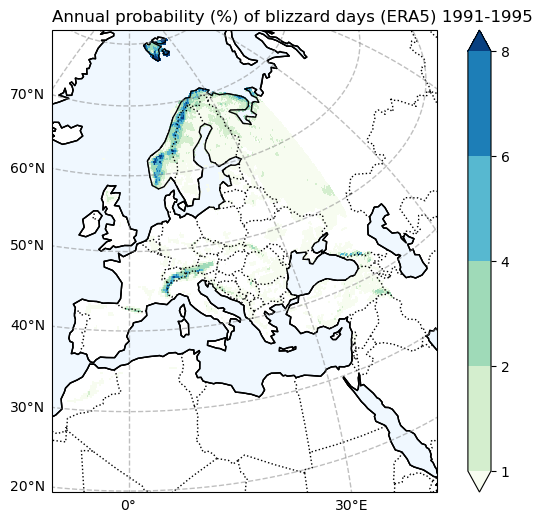

In [9]:
fig, ax = make_map(f'Annual probability (%) of blizzard days (ERA5) {Hist_start_year}-{Hist_end_year}')

BdayCount_anaProb_mean_ERA.plot(
    ax=ax,
    levels=[1, 2, 4, 6, 8],
    cbar_kwargs={"label": ""},
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)

fig.savefig(
    os.path.join(plot_dir, f'Annual_probability_of_blizzard_days_ERA5_{Hist_start_year}_{Hist_end_year}.png')
)

### Blizzard plot for CORDEX

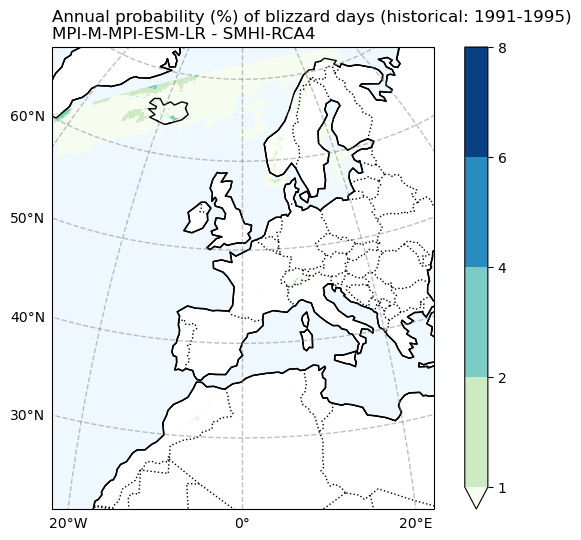

In [10]:
fig, ax = make_map(f'Annual probability (%) of blizzard days ({Hist_experiment_in}: {Hist_start_year}-{Hist_end_year})\n{gcm_model_Name} - {rcm_model_Name}')

BdayCount_anaProb_hist_mean.drop_vars(['rotated_pole', 'height']).plot.pcolormesh(
    ax=ax,
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    levels=[1, 2, 4, 6, 8],
    cbar_kwargs={"label": ""},
    cmap='GnBu',
    add_colorbar=True
)

fig.savefig(os.path.join(plot_dir, f'Annual_probability_of_blizzard_days_hist_{cordex_suffix_hist}.png'))

### Probability of snowfall days > 6 cm (ERA5)

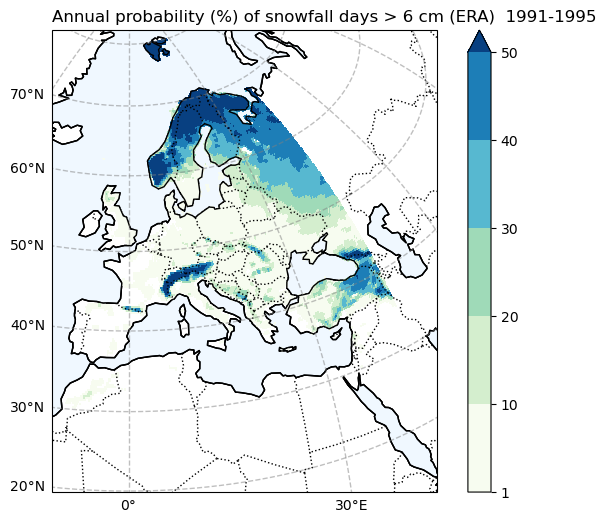

In [11]:
# Filter the data to exclude values less than 1
filtered_data = snow6Prob_annual_mean_ERA.where(snow6Prob_annual_mean_ERA >= 1)

fig, ax = make_map(f'Annual probability (%) of snowfall days > 6 cm (ERA)  {Hist_start_year}-{Hist_end_year}')

filtered_data.plot(
    ax=ax,
    levels=[1, 10, 20, 30, 40, 50],
    cmap="GnBu",
    cbar_kwargs={"label": ""},
    transform=ccrs.PlateCarree(),
)

fig.savefig(
    os.path.join(plot_dir, f'Annual_probability_of_snowfall_days_6cm_ERA_{Hist_start_year}_{Hist_end_year}.png')
)

### Probability of snowfall days > 6 cm (CORDEX)

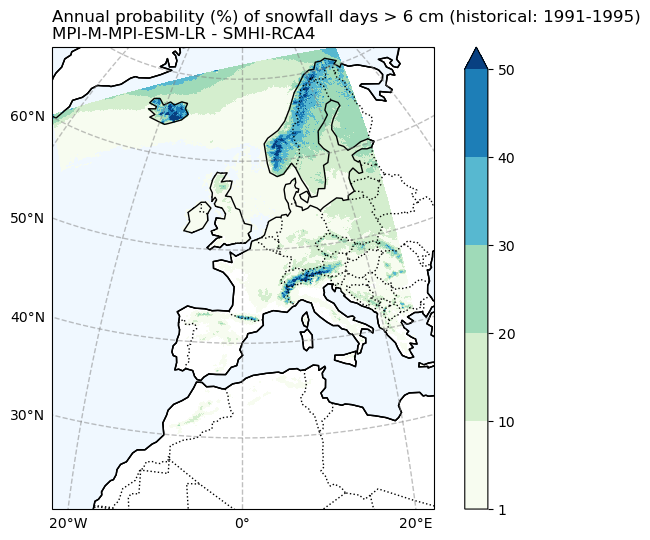

In [12]:
# Filter the data to exclude values less than 1
filtered_data = snow6Prob_annual_hist_mean.where(snow6Prob_annual_hist_mean >= 1)
filtered_data = filtered_data.drop_vars(['rotated_pole', 'height'])

fig, ax = make_map(f'Annual probability (%) of snowfall days > 6 cm ({Hist_experiment_in}: {Hist_start_year}-{Hist_end_year})\n{gcm_model_Name} - {rcm_model_Name}')

filtered_data.plot.pcolormesh(
    ax=ax,
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    levels=[1, 10, 20, 30, 40, 50],
    cbar_kwargs={"label": ""},
    cmap='GnBu',
    add_colorbar=True
)

fig.savefig(
    os.path.join(plot_dir, f'Annual_probability_of_snowfall_days_6cm_hist_{cordex_suffix_hist}.png')
)

### Probability of snowfall days > 25 cm (ERA5)

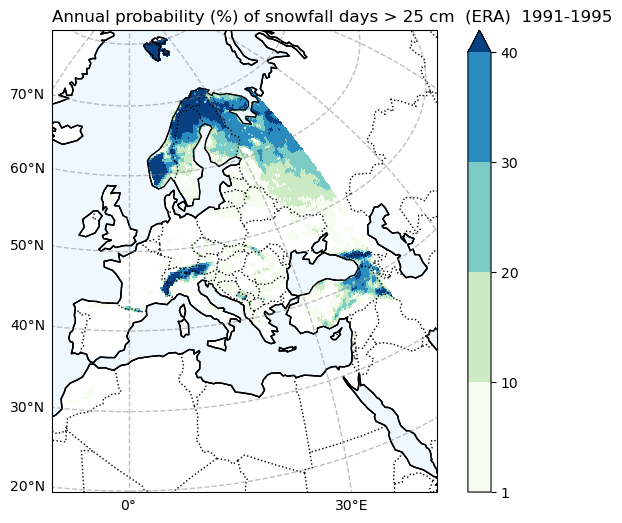

In [13]:
# Filter the data to exclude values less than 1
filtered_data = snow25Prob_annual_mean_ERA.where(snow25Prob_annual_mean_ERA >= 1)

fig, ax = make_map(f'Annual probability (%) of snowfall days > 25 cm  (ERA)  {Hist_start_year}-{Hist_end_year}')

filtered_data.plot(
    ax=ax,
    levels=[1, 10, 20, 30, 40],
    cmap="GnBu",
    cbar_kwargs={"label": " "},
    transform=ccrs.PlateCarree(),
)

fig.savefig(
    os.path.join(plot_dir, f'Annual_probability_of_snowfall_days_25cm_ERA_{Hist_start_year}_{Hist_end_year}.png')
)

### Probability of snowfall days > 25 cm (CORDEX)

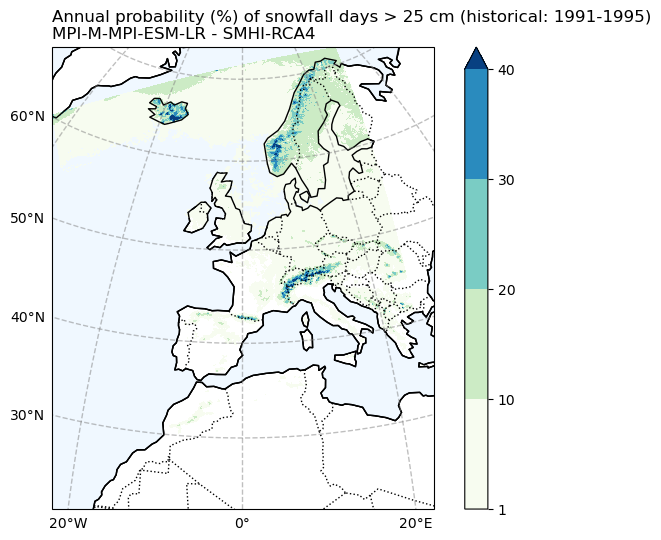

In [14]:
# Filter the data to exclude values less than 1
filtered_data = snow25Prob_annual_hist_mean.where(snow25Prob_annual_hist_mean >= 1)
filtered_data = filtered_data.drop_vars(['rotated_pole', 'height'])

fig, ax = make_map(f'Annual probability (%) of snowfall days > 25 cm ({Hist_experiment_in}: {Hist_start_year}-{Hist_end_year})\n{gcm_model_Name} - {rcm_model_Name}')

filtered_data.plot.pcolormesh(
    ax=ax,
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    levels=[1, 10, 20, 30, 40],
    cbar_kwargs={"label": ""},
    cmap='GnBu',
    add_colorbar=True
)

fig.savefig(
    os.path.join(plot_dir,f'Annual_probability_of_snowfall_days_25cm_hist_{cordex_suffix_hist}.png')
)

## Conclusions
In this workflow, we have demonstrated the procedure of exploring, processing, and visualizing the data required for snow and blizzard calculation.

These indices represent annual probabilities, indicating the likelihood of specific events occurring over multiple years.

The snow and blizzard hazard maps obtained and saved locally in this workflow will be utilized in the subsequent snow and blizzard risk workflow, which is a component of the risk toolbox.

Comparing the historical simulation from CORDEX with the ERA5 reanalysis, it is evident that the CORDEX model (Here, we use only one model, and utilizing multiple models for simulation may yield differing results.) notably underestimates the frequency of blizzard days and heavy snow events. It's important to note that when analyzing these indices over mountainous regions, the coarse resolution of the data may not accurately represent the topography, leading to potentially erroneous results.

## Contributors

- Suraj Polade, Finnish Meteorological Institute
- Andrea Vajda, Finnish Meteorological Institute